# Tutorial 41: Mean Relativistic Drawdown at Risk (RLDaR) Optimization

## 1. Downloading the data:

In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'AMZN', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'AAPL', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  25 of 25 completed


In [13]:
# Calculating returns

Y = data[assets].iloc[-300:,:].pct_change().dropna()

display(Y.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-19,1.5230%,-0.3778%,0.0475%,-0.8599%,-1.4333%,-3.0011%,0.1113%,1.2968%,3.4361%,-0.8763%,...,1.6740%,0.1475%,0.6339%,-0.1823%,-0.7728%,1.1385%,-1.1145%,-1.2872%,0.4574%,-0.8025%
2018-10-22,0.6110%,1.4325%,-1.9240%,-0.0786%,-0.6335%,-6.2983%,-0.6392%,-1.1024%,0.0527%,-0.3221%,...,-1.0331%,0.8927%,-0.8661%,0.4483%,-2.8972%,-0.6085%,-0.6075%,-0.8634%,0.1457%,-3.4490%
2018-10-23,0.9427%,-1.1513%,-3.6571%,-1.6658%,-0.4202%,-0.4521%,-0.2797%,-0.5034%,0.1845%,-3.9948%,...,0.8808%,-1.3956%,0.4766%,-5.1240%,-0.0321%,1.0713%,-1.0808%,-1.8308%,4.0560%,4.0353%
2018-10-24,-3.4302%,-5.9083%,-4.5500%,1.3141%,-1.8042%,-3.5933%,-4.2917%,0.8674%,0.9995%,-4.1109%,...,0.7437%,-5.3469%,3.5178%,-4.2683%,-1.3479%,-8.0557%,-1.2403%,-4.2187%,0.3671%,-3.3065%
2018-10-25,2.1898%,7.0887%,0.4741%,2.5715%,0.5186%,0.7783%,5.0410%,-0.5733%,-1.1719%,2.1585%,...,1.3642%,5.8444%,-1.0309%,0.4914%,0.9109%,-1.2516%,4.3662%,1.3800%,-1.7241%,3.3538%


## 2. Estimating Mean Relativistic Drawdown at Risk (RLDaR) Portfolios

### Mean Relativistic Drawdown at Risk (RLDaR) 포트폴리오 모델 설명

**Mean Relativistic Drawdown at Risk (RLDaR)** 포트폴리오 모델은 포트폴리오의 최대 낙폭(Drawdown) 리스크를 상대론적 접근법을 사용하여 최적화하는 방법입니다. 이 모델은 포트폴리오의 수익률 변동성을 고려하여 투자자의 리스크 관리에 중요한 정보를 제공합니다. RLDaR은 Drawdown을 측정하고 이를 최소화하기 위한 리스크 관리 도구로 사용됩니다.

### RLDaR 정의

RLDaR은 특정 신뢰수준에서 포트폴리오의 최대 예상 낙폭을 측정합니다. 이는 전통적인 최대 낙폭(Max Drawdown) 측정치와 유사하지만, 상대론적 접근법을 통해 더 현실적인 시장 상황을 반영합니다.

### RLDaR를 사용한 포트폴리오 최적화

RLDaR를 사용한 포트폴리오 최적화는 다음과 같은 형태를 취합니다:

1. **목표 함수 (Objective Function)**:
   $$ \min_w \, \text{RLDaR}(w) $$
   여기서 $ w $는 포트폴리오 가중치 벡터입니다.

2. **제약 조건 (Constraints)**:
   - 가중치의 합은 1이어야 합니다:
     $$ \sum_{i=1}^{n} w_i = 1 $$
   - 각 자산의 가중치는 특정 범위 내에 있어야 합니다:
     $$ l_i \leq w_i \leq u_i $$

### RLDaR 포트폴리오 최적화 예제 코드

아래는 `Riskfolio-Lib`를 사용하여 RLDaR 포트폴리오를 최적화하는 예제 코드입니다:

```python
import numpy as np
import pandas as pd
import riskfolio as rp
import matplotlib.pyplot as plt

# 예시 데이터 생성
np.random.seed(42)
Y = np.random.randn(100, 10)  # 100개의 샘플과 10개의 자산
asset_names = [f'Asset {i}' for i in range(1, 11)]
returns = pd.DataFrame(Y, columns=asset_names)

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=returns)

# 기대 수익률 및 공분산 행렬 추정
method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# 최적화 매개변수 설정
model = 'Classic'  # 사용할 모델: Classic (historical), BL (Black Litterman), FM (Factor Model)
rm = 'RLDaR'  # 리스크 측정치로 RLDaR 사용
obj = 'Sharpe'  # 목표 함수: Sharpe 비율 최대화
hist = True  # 역사적 시나리오 사용 여부
rf = 0  # 무위험 이자율
l = 0  # 리스크 회피 계수 (유틸리티 목표 함수에서만 사용)

# 최적 포트폴리오 계산
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# 히스토그램 플롯
ax = rp.plot_hist(returns=Y, w=w, alpha=0.05, bins=50, height=6, width=10, ax=None)

# 플롯 표시
plt.show()
```

### 코드 설명

1. **데이터 준비 및 포트폴리오 객체 생성**:
   ```python
   np.random.seed(42)
   Y = np.random.randn(100, 10)
   asset_names = [f'Asset {i}' for i in range(1, 11)]
   returns = pd.DataFrame(Y, columns=asset_names)
   port = rp.Portfolio(returns=returns)
   ```

   - 예시 데이터를 생성하고 자산 이름을 설정합니다.
   - `rp.Portfolio` 클래스를 사용하여 포트폴리오 객체를 생성합니다.

2. **기대 수익률 및 공분산 행렬 추정**:
   ```python
   method_mu = 'hist'
   method_cov = 'hist'
   port.assets_stats(method_mu=method_mu, method_cov=method_cov)
   ```

   - 역사적 데이터를 기반으로 기대 수익률 및 공분산 행렬을 추정합니다.

3. **최적화 매개변수 설정**:
   ```python
   model = 'Classic'
   rm = 'RLDaR'
   obj = 'Sharpe'
   hist = True
   rf = 0
   l = 0
   ```

   - 클래식 모델을 사용하고, RLDaR를 리스크 측정치로 설정하며, 목표 함수를 Sharpe 비율 최대화로 설정합니다.
   - 역사적 시나리오를 사용하며, 무위험 이자율은 0으로 설정합니다.

4. **최적 포트폴리오 계산**:
   ```python
   w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
   ```

   - 지정된 매개변수에 따라 포트폴리오를 최적화합니다.

5. **히스토그램 플롯 및 표시**:
   ```python
   ax = rp.plot_hist(returns=Y, w=w, alpha=0.05, bins=50, height=6, width=10, ax=None)
   plt.show()
   ```

   - `plot_hist` 함수를 사용하여 히스토그램을 플롯하고, 최적화된 포트폴리오의 수익률 분포를 시각화합니다.

### 결론

Mean Relativistic Drawdown at Risk (RLDaR) 포트폴리오 모델은 포트폴리오의 최대 낙폭 리스크를 상대론적 접근법을 통해 현실적으로 반영하는 리스크 관리 도구입니다. RLDaR를 사용하면 투자자의 리스크 선호도에 맞춘 포트폴리오 최적화를 통해 극단적 손실을 효과적으로 관리할 수 있습니다. 위 예제 코드는 RLDaR 포트폴리오를 최적화하는 방법을 보여주며, 다양한 투자 전략을 검토하고 실행하는 데 도움이 됩니다.

Cajas(2023)가 제안한 Relativistic Drawdown at Risk (RLDaR) 포트폴리오 모델은 포트폴리오 수익률의 RDVaR을 포트폴리오 Entropic Drawdown at Risk (EDaR)와 유사한 방식으로 최적화하는 방법을 보여줍니다. RLDaR은 Kaniadakis 엔트로피에 기반한 EDaR의 일반화된 형태로, 일관된 리스크 측정치입니다.

RLDaR 모델은 파워 콘(power cone)을 사용하므로 RLDaR을 최적화할 때 MOSEK를 사용하는 것이 권장됩니다.

MOSEK 설치 지침은 다음 링크에서 확인할 수 있으며, Anaconda를 사용하는 것이 좋습니다. 또한, 학술용 라이선스를 요청하는 것을 권장합니다.

- [MOSEK 설치 지침](https://www.mosek.com/products/academic-licenses/)

### 2.1 Calculating the portfolio that optimize return/RLVaR ratio.

In [14]:
import riskfolio as rp
import mosek

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov,
                  )

# Estimate optimal portfolio:

port.solvers = ['MOSEK'] # It is recommended to use mosek when optimizing GMD
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

kappa = 0.3
alpha = 0.2
port.kappa = kappa
port.alpha = alpha

model ='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'EDaR' 
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,3.6408%,0.0000%,0.0000%,7.4013%,0.0000%,...,0.0000%,30.1618%,13.1019%,44.7413%,0.0000%,0.9529%,0.0000%,0.0000%,0.0000%,0.0000%


이 코드는 `Riskfolio-Lib`를 사용하여 Entropic Drawdown at Risk (EDaR)를 최적화하는 포트폴리오를 계산하는 예제입니다. MOSEK 솔버를 사용하여 최적화를 수행하며, 기대 수익률 및 공분산 행렬을 역사적 데이터를 기반으로 추정합니다. 각 단계별로 코드를 설명하겠습니다.

### 코드 설명

1. **필요한 라이브러리 임포트**:
   ```python
   import riskfolio as rp
   import mosek
   ```

   - `riskfolio` 및 `mosek` 라이브러리를 임포트합니다.

2. **포트폴리오 객체 생성**:
   ```python
   port = rp.Portfolio(returns=Y)
   ```

   - `rp.Portfolio` 클래스를 사용하여 포트폴리오 객체를 생성합니다.
   - `returns=Y`: 자산의 역사적 수익률 데이터 `Y`를 사용합니다.

3. **기대 수익률 및 공분산 행렬 추정**:
   ```python
   method_mu='hist'  # 역사적 데이터를 사용하여 기대 수익률 추정
   method_cov='hist'  # 역사적 데이터를 사용하여 공분산 행렬 추정

   port.assets_stats(method_mu=method_mu, method_cov=method_cov)
   ```

   - `method_mu='hist'`: 역사적 데이터를 기반으로 기대 수익률을 추정합니다.
   - `method_cov='hist'`: 역사적 데이터를 기반으로 공분산 행렬을 추정합니다.
   - `port.assets_stats` 함수는 지정된 방법에 따라 자산의 통계를 계산합니다.

4. **MOSEK 솔버 설정**:
   ```python
   port.solvers = ['MOSEK']  # EDaR 최적화를 위해 MOSEK 솔버 사용
   port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}
   ```

   - `port.solvers = ['MOSEK']`: MOSEK 솔버를 사용하여 최적화를 수행하도록 설정합니다.
   - `port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}`: MOSEK 솔버 매개변수를 설정하여 최적화에 사용할 스레드 수를 2로 설정합니다.

5. **kappa 및 alpha 매개변수 설정**:
   ```python
   kappa = 0.3
   alpha = 0.2
   port.kappa = kappa
   port.alpha = alpha
   ```

   - `kappa`와 `alpha` 매개변수를 설정합니다. 이 값들은 EDaR 계산에 사용됩니다.

6. **최적화 매개변수 설정**:
   ```python
   model ='Classic'  # 사용할 모델: Classic (historical), BL (Black Litterman) 또는 FM (Factor Model)
   rm = 'EDaR'  # 리스크 측정치: EDaR 사용
   obj = 'Sharpe'  # 목표 함수: Sharpe 비율 최대화
   hist = True  # 역사적 시나리오 사용 여부
   rf = 0  # 무위험 이자율
   l = 0  # 리스크 회피 계수 (유틸리티 목표 함수에서만 사용)
   ```

   - `model`: 클래식 모델을 사용합니다.
   - `rm`: EDaR를 리스크 측정치로 사용합니다.
   - `obj`: Sharpe 비율을 최대화하는 목표 함수로 설정합니다.
   - `hist`: 역사적 시나리오 사용 여부를 설정합니다.
   - `rf`: 무위험 이자율을 0으로 설정합니다.
   - `l`: 리스크 회피 계수를 0으로 설정합니다.

7. **최적 포트폴리오 계산**:
   ```python
   w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
   ```

   - `port.optimization` 함수를 사용하여 지정된 매개변수에 따라 포트폴리오를 최적화합니다.
   - 최적화된 포트폴리오 가중치 벡터 `w`를 반환합니다.

8. **결과 출력**:
   ```python
   display(w.T)
   ```

   - `display(w.T)` 함수를 사용하여 최적화된 포트폴리오 가중치를 전치하여 보기 좋게 출력합니다.

### 전체 코드

```python
import riskfolio as rp
import mosek

# 포트폴리오 객체 생성
port = rp.Portfolio(returns=Y)

# 기대 수익률 및 공분산 행렬 추정
method_mu = 'hist'  # 역사적 데이터를 사용하여 기대 수익률 추정
method_cov = 'hist'  # 역사적 데이터를 사용하여 공분산 행렬 추정
port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# MOSEK 솔버 설정
port.solvers = ['MOSEK']
port.sol_params = {'MOSEK': {'mosek_params': {mosek.iparam.num_threads: 2}}}

# kappa 및 alpha 매개변수 설정
kappa = 0.3
alpha = 0.2
port.kappa = kappa
port.alpha = alpha

# 최적화 매개변수 설정
model = 'Classic'
rm = 'EDaR'
obj = 'Sharpe'
hist = True
rf = 0
l = 0

# 최적 포트폴리오 계산
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

# 결과 출력
display(w.T)
```

이 코드는 Entropic Drawdown at Risk (EDaR)를 최적화하는 포트폴리오를 계산합니다. MOSEK 솔버를 사용하여 높은 계산 성능을 확보하고, 역사적 데이터를 기반으로 자산의 기대 수익률 및 공분산 행렬을 추정합니다. 최적화된 포트폴리오 가중치를 계산하고 출력하여 최적의 투자 전략을 확인할 수 있습니다.

### Kappa 및 Alpha 매개변수 설명

**Kappa**와 **Alpha**는 Entropic Drawdown at Risk (EDaR) 및 Relativistic Drawdown at Risk (RLDaR) 모델의 중요한 매개변수입니다. 이 매개변수들은 모델이 포트폴리오 리스크를 측정하고 최적화하는 방식을 결정하는 데 중요한 역할을 합니다.

#### Kappa (κ)
- **Kappa (κ)**는 Kaniadakis 엔트로피의 왜곡 매개변수입니다.
- 이 매개변수는 엔트로피의 비대칭성을 제어합니다. 엔트로피의 비대칭성은 시장의 극단적인 변화나 이상 현상을 더 잘 반영하도록 합니다.
- Kappa 값이 클수록 엔트로피가 더 비대칭적이 되며, 이는 리스크 관리에서 극단적인 손실이나 이익을 더 잘 반영할 수 있게 합니다.

#### Alpha (α)
- **Alpha (α)**는 신뢰 수준을 나타내는 매개변수입니다.
- 이는 포트폴리오 리스크 측정치의 민감도를 조정합니다. Alpha 값이 낮을수록 모델이 더 보수적으로 리스크를 평가하며, 값이 높을수록 리스크 평가가 더 공격적이 됩니다.
- 일반적으로 0과 1 사이의 값을 가지며, Alpha 값이 0.05라면 이는 95% 신뢰 수준에서 리스크를 평가하는 것을 의미합니다.


### 2.2 Plotting portfolio composition

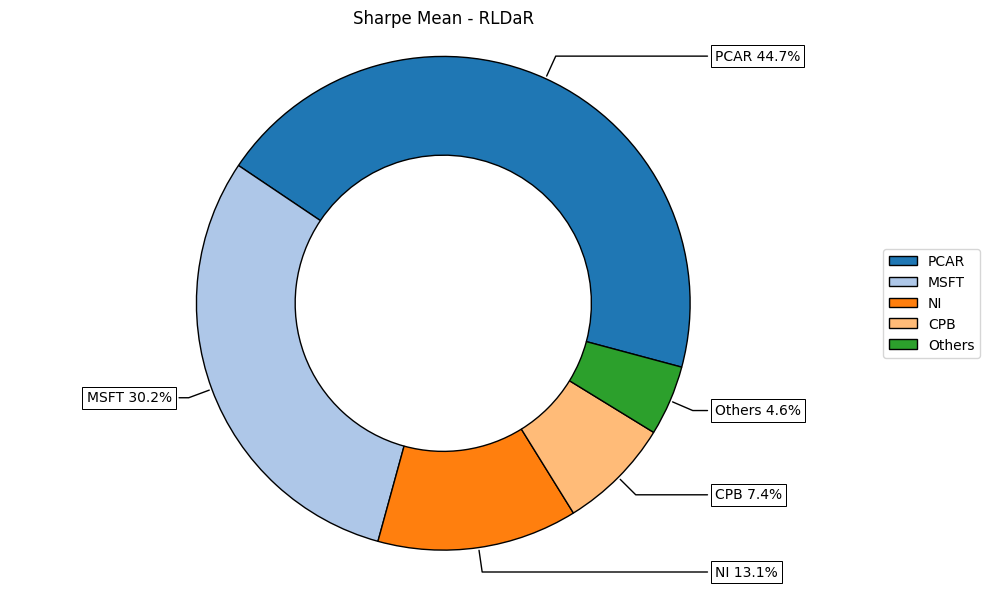

In [15]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='Sharpe Mean - RLDaR',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

### 2.3 Plotting risk measures

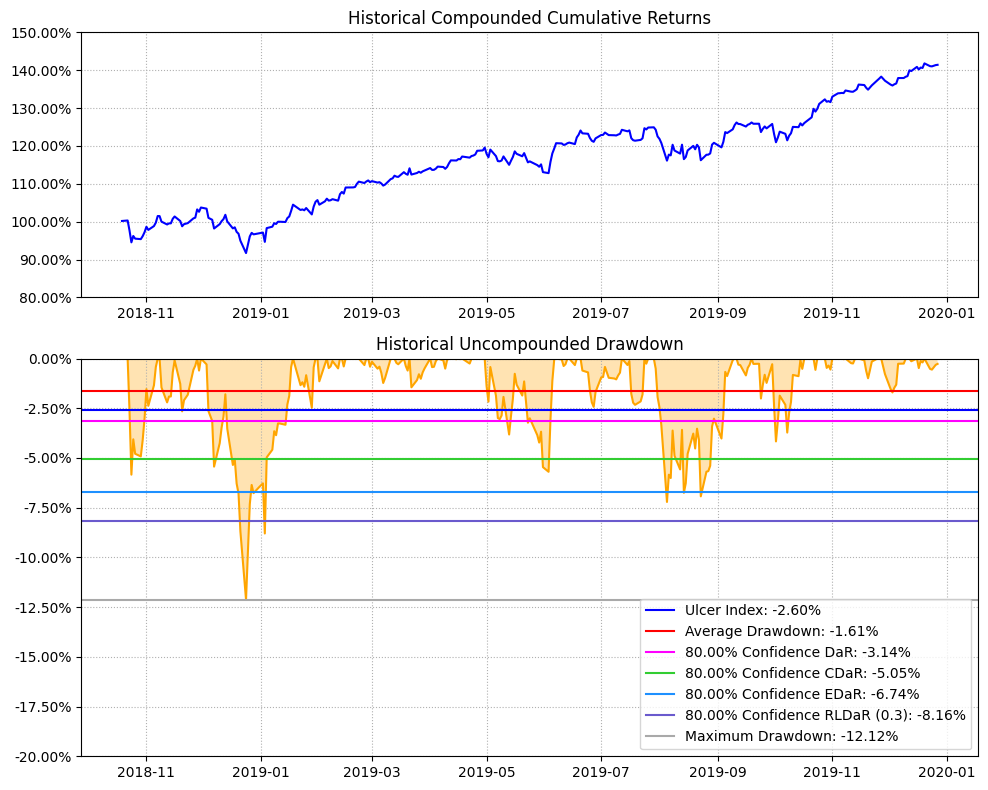

In [16]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)

### 2.4 Calculate efficient frontier

In [17]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,0.0000%,0.0000%,2.5461%,6.9846%,0.0000%,14.9683%,0.0000%,0.0000%,...,0.0000%,0.0000%,32.5726%,21.0480%,0.9555%,5.7804%,0.0000%,0.0000%,15.1445%,0.0000%
1,0.0000%,0.0000%,0.0000%,0.0000%,4.7265%,8.3183%,0.0000%,6.5857%,0.0000%,0.0000%,...,0.0000%,0.0000%,36.7043%,26.7701%,7.9535%,0.7625%,0.0000%,0.0000%,8.1791%,0.0000%
2,0.0000%,0.0000%,0.0000%,0.0000%,2.8304%,8.7009%,0.0000%,3.9144%,1.5093%,0.0000%,...,0.0000%,0.0000%,38.0148%,29.5250%,9.7196%,0.7007%,0.0000%,0.0000%,5.0848%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%,0.3957%,9.1497%,0.0000%,0.8927%,2.9079%,0.0000%,...,0.0000%,0.0000%,40.3489%,31.7932%,11.4502%,0.5361%,0.0000%,0.0000%,2.5257%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,9.2910%,0.0000%,0.3283%,4.5331%,0.0000%,...,0.0000%,0.0000%,39.1087%,34.3702%,11.1996%,1.1458%,0.0000%,0.0000%,0.0233%,0.0000%


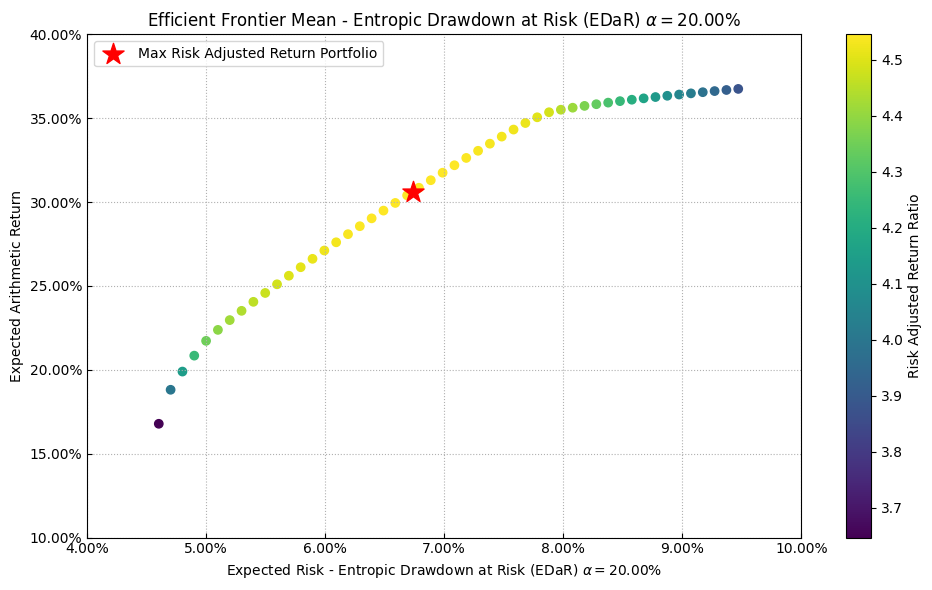

In [18]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      cmap='viridis',
                      w=w,
                      label=label,
                      marker='*',
                      s=16,
                      c='r',
                      height=6,
                      width=10,
                      ax=None)

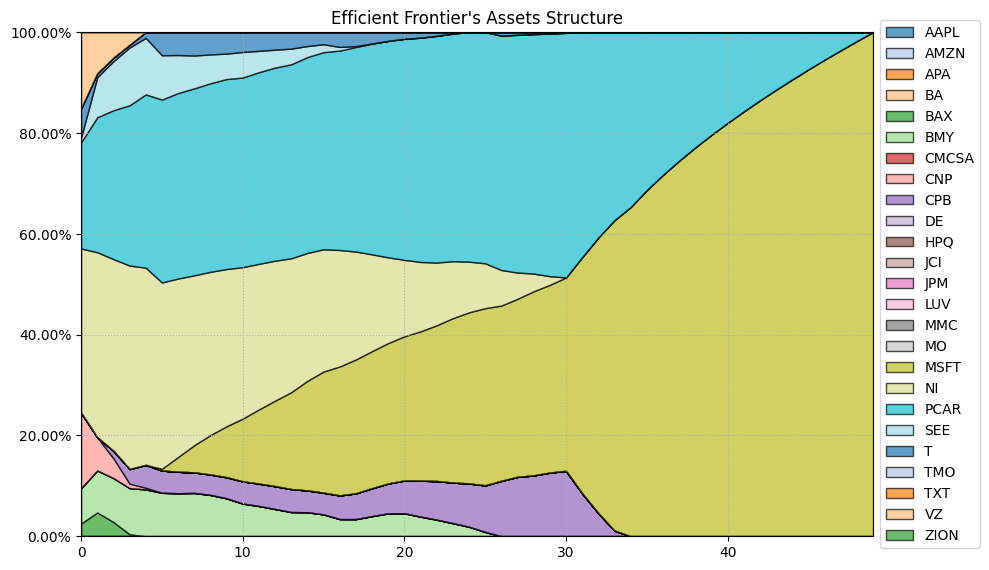

In [19]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios for Relativistic Drawdown at Risk

### 3.1 Calculating the risk parity portfolio for Relativistic Drawdown at Risk.

In [20]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,AAPL,AMZN,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,...,MO,MSFT,NI,PCAR,SEE,T,TMO,TXT,VZ,ZION
weights,2.0960%,1.9982%,1.2990%,2.7527%,5.4417%,5.6356%,3.1832%,12.2835%,3.8515%,3.0014%,...,3.2538%,3.4736%,7.7865%,5.9182%,6.1280%,4.2823%,2.7283%,1.7643%,7.3737%,2.1190%


### 3.2 Plotting portfolio composition

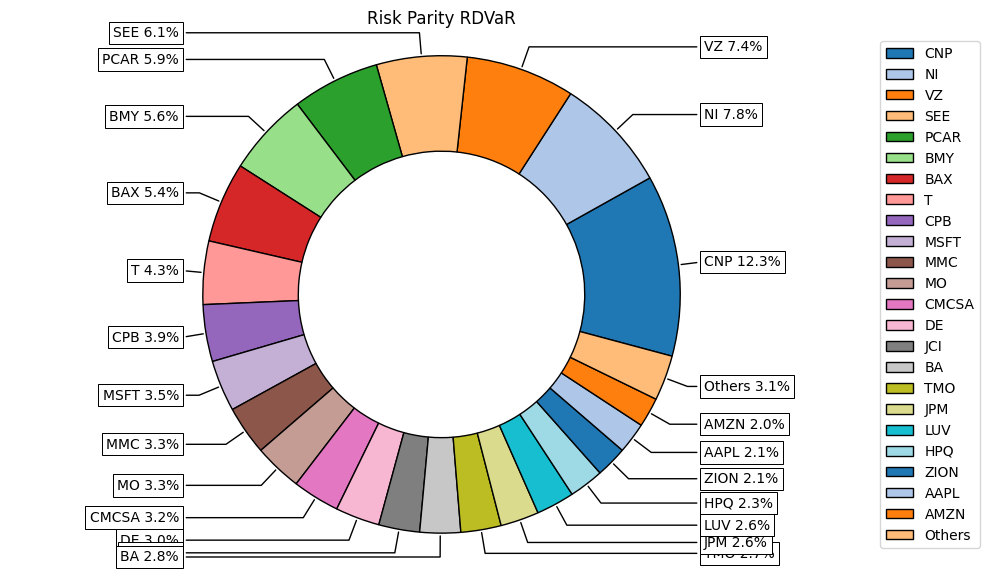

In [21]:
ax = rp.plot_pie(w=w_rp,
                 title='Risk Parity RDVaR',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=6,
                 width=10,
                 ax=None)

### 3.3 Plotting Risk Composition

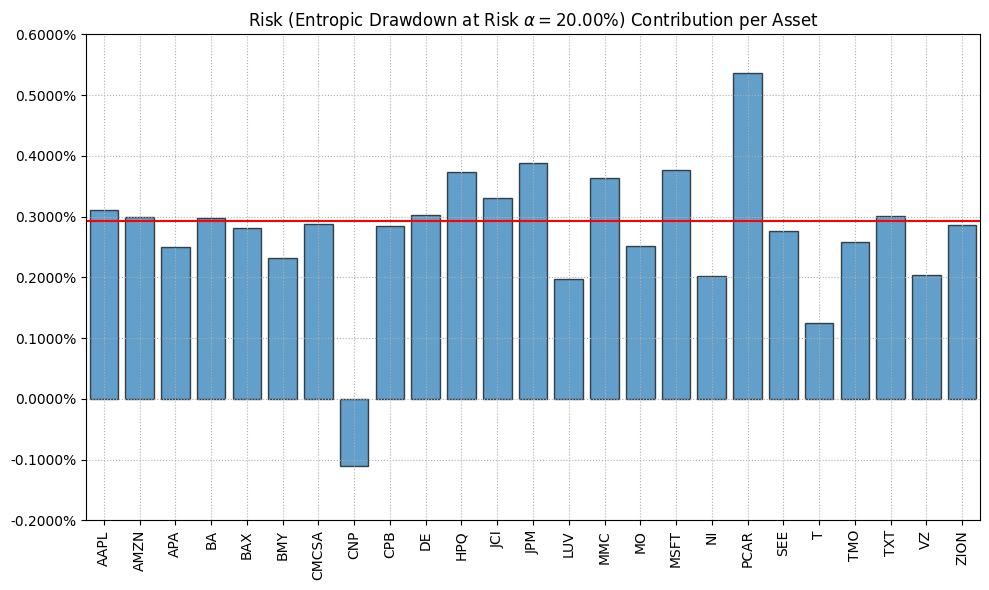

In [22]:
ax = rp.plot_risk_con(w_rp,
                      cov=port.cov,
                      returns=port.returns,
                      rm=rm,
                      rf=0,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      color="tab:blue", height=6, width=10, ax=None)

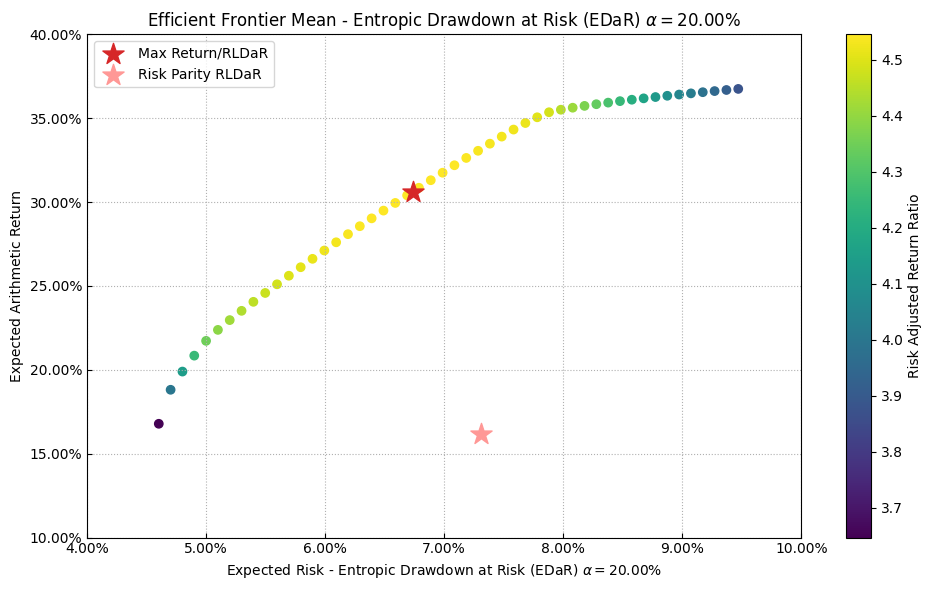

In [23]:
# Plotting the efficient frontier
ws = pd.concat([w, w_rp],axis=1)
ws.columns = ["Max Return/RLDaR", "Risk Parity RLDaR"]

mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier,
                      mu=mu,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=rf,
                      alpha=alpha,
                      kappa=kappa,
                      solver='MOSEK',
                      cmap='viridis',
                      w=ws,
                      marker='*',
                      s=16,
                      height=6,
                      width=10,
                      ax=None)